## Cardiovascular Risk Prediction in Cleveland Population: A Predictive Analysis of Heart Disease Occurrence

## Introduction

Coronary diseases pose significant challenges to everyday wellbeing, requiring precise predictive models where understanding diagnostic factors is crucial. Utilizing a dataset of clinical test results and cardiovascular diagnosis, this analysis focuses on the relationship between age, maximum heart rate, and diagnosis levels in Cleveland. The unique healthcare landscape and lifestyle factors make this exploration essential for tailored interventions and improved cardiovascular risk assessment in the Cleveland population. Thus, this project will explore the following: Can maximum heart rate and age be used to predict heart disease in Clevelanders?

This analysis' heart disease dataset is from a database created to test a discriminant function model, developed using clinical and noninvasive test results from patients undergoing angiography. Collected from groups in Hungary, Switzerland, Long Beach, and Cleveland, the database encompasses variables including demographics, chest pain, resting blood pressure, cholesterol levels, maximum heart rate and other relevant features for diagnosis. The proposed model focuses on the dataset of 303 Cleveland Clinic patients. 

## Prelim Analysis

In [6]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [11]:
# downloading and reading data, naming columns
url <- "https://raw.githubusercontent.com/ssun05/dsci_100_002_group5_project/main/processed.cleveland.data"
heart_data <- read_csv(url, col_names = c("age", "sex", "chest_pain", "trestbps", "chol", "fasting_bld_sgar",
                                                      "restecg", "max_heart_rate", "exerc_angina", "oldpeak", "slope", "ca", "thal", "diagnosis"))

heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, chest_pain, trestbps, chol, fasting_bld_sgar, restecg, m...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [16]:
# filter for males and reclass diagnosis as factor, make labels understandable
heart_data_renamed <- heart_data |> 
                    mutate(diagnosis = as_factor(diagnosis)) |>
                    mutate(diagnosis = fct_recode(diagnosis, "no" = "0", "yes" = "1", "yes" = "2", "yes" = "3", "yes" = "4"))

heart_data_renamed

age,sex,chest_pain,trestbps,chol,fasting_bld_sgar,restecg,max_heart_rate,exerc_angina,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,no
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,no


In [17]:
heart_split <- initial_split(heart_data_renamed, prop = 0.75, strata = diagnosis)

heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [18]:
# table of diagnosis counts
label_counts <- heart_train |>
                group_by(diagnosis) |>
                summarize(count = n())
label_counts

missing_data <- heart_train |> 
                filter(age == NA | max_heart_rate == NA | diagnosis == NA |
                       age == "?" | max_heart_rate == "?" | diagnosis == "?") |>
                    summarize(missing_data = n())

missing_data

diagnosis,count
<fct>,<int>
no,123
yes,104


missing_data
<int>
0


diagnosis,mean_heart
<fct>,<dbl>
no,157.7317
yes,140.4038


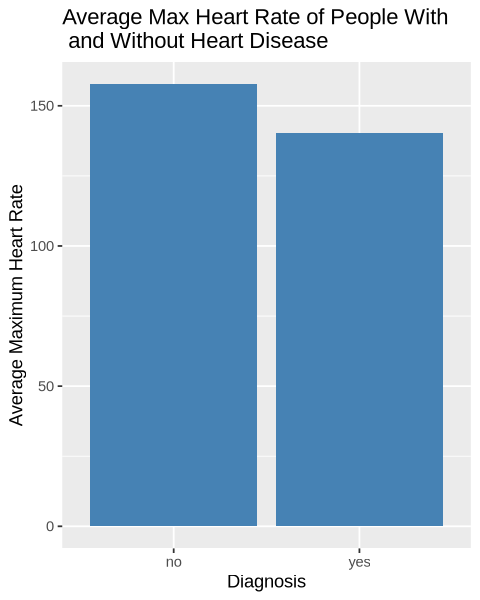

In [19]:
# predictor mean: heart rate
mean_max_hrt_rate <- heart_train |>
                        group_by(diagnosis) |>
                        summarize(mean_heart = mean(max_heart_rate))

mean_max_hrt_rate

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_max_hrt_rate |> 
                ggplot(aes(x = diagnosis, y = mean_heart)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Maximum Heart Rate") +
                ggtitle("Average Max Heart Rate of People With \n and Without Heart Disease")

avg_hrt_plot

diagnosis,mean_age
<fct>,<dbl>
no,52.09756
yes,56.60577


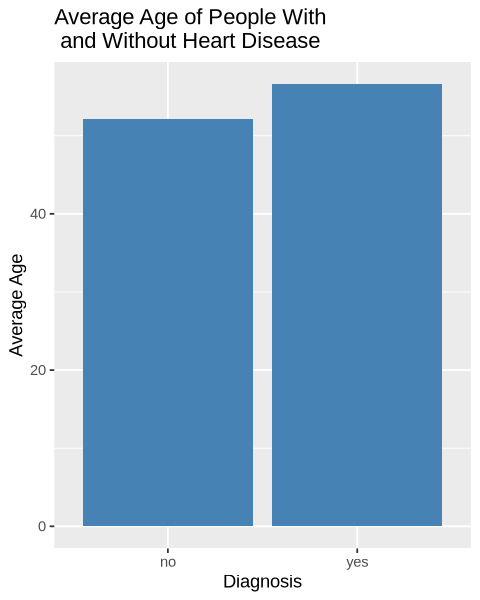

In [20]:
# predictor mean: age
mean_age <- heart_train |>
                group_by(diagnosis) |>
                summarize(mean_age = mean(age))

mean_age

options(repr.plot.width = 4, repr.plot.height = 5)
avg_hrt_plot <- mean_age |> 
                ggplot(aes(x = diagnosis, y = mean_age)) +
                geom_bar(stat = "identity", fill = "steelblue") +
                labs(x = "Diagnosis", y = "Average Age") +
                ggtitle("Average Age of People With \n and Without Heart Disease")

avg_hrt_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


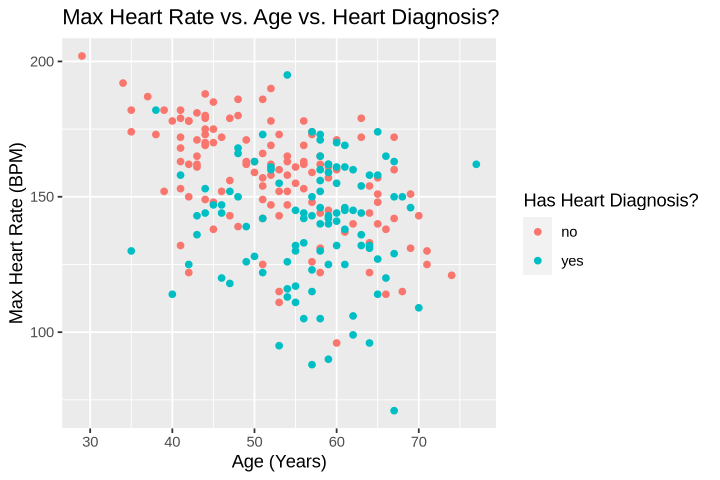

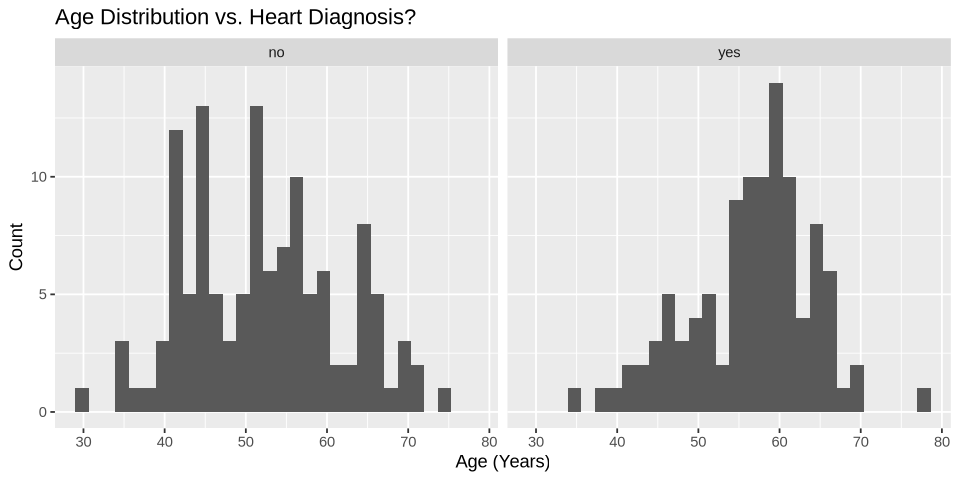

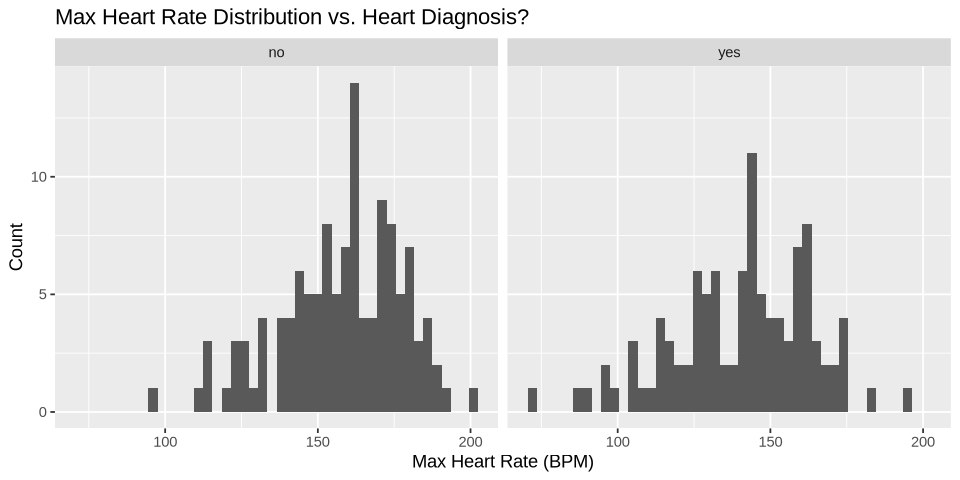

In [21]:
options(repr.plot.width = 6, repr.plot.height = 4)

heart_plot <- heart_train|> 
                ggplot(aes(x = age, y = max_heart_rate, color = diagnosis)) +
                geom_point() +
                labs(x = "Age (Years)",
                     y = "Max Heart Rate (BPM)",
                     color = "Has Heart Diagnosis?",
                     title = "Max Heart Rate vs. Age vs. Heart Diagnosis?")

heart_plot

options(repr.plot.width = 8, repr.plot.height = 4)

age_distribution <- heart_train|> 
                ggplot(aes(x = age)) +
                geom_histogram() +
                labs(x = "Age (Years)",
                     y = "Count",
                     title = "Age Distribution vs. Heart Diagnosis?") +
                facet_grid(cols = vars(diagnosis))

age_distribution

max_distribution <- heart_train|> 
                ggplot(aes(x = max_heart_rate)) +
                geom_histogram(binwidth = 3) +
                labs(x = "Max Heart Rate (BPM)",
                     y = "Count",
                     title = "Max Heart Rate Distribution vs. Heart Diagnosis?") +
                facet_grid(cols = vars(diagnosis))

max_distribution

## Methods

We will answer the research question using a knn classification model with "age" and "max_heart_rate" variables as predictors, and the presence of a diagnosis as the class label. After repeated testing we found that age and max heart rate allows for the most predictive power in this application.

We decided to use knn classification instead of knn regression due to the nature of the question we are trying to answer. Diagnosis takes on values from 0 - 4 which appears quantitative, but is more categorical in nature because each value represents a category of heart disease severity. In order to make this distinction clearer we decided to categorize these values into two: "no" (0) and "yes" (1 - 4) which simply indicates the presence of heart disease or not.

"yes" will be treated as the positive class. We want to ensure that anyone with heart disease is correctly identified. We will perform an analysis in order to determine the k value maximizing our recall, minimizing the amount of false negatives.

Finally to build our classifier we will create an workflow that contains a recipe that scales and centers all predictors, and KNN classification spec. model with our determined k value.

We will visualize our results with a confusion matrix summarizing the observations and our classifier's predictions.

## Expected Outcomes and Significance

We expect that younger individuals with lower maximum heart rates will have lower rates of heart disease, while older individuals with higher maximum heart rates will have higher risk of heart disease occurrence. 

This analysis is significant in that medical professionals may use this information to identify high-risk individuals and tailor preventive strategies, emphasizing lifestyle modifications. Also, these findings could influence healthcare policy and interventions, directing resources and preventive measures toward populations with higher risk factors. Further research could explore which factor has more influence on heart disease, and evaluate the effectiveness of interventions based on age and maximum heart rates. 
